# **Прогнозування часових рядів за допомогою TensorFlow**

TensorFlow стає потужним інструментом для дослідників даних, які виконують аналіз часових рядів завдяки своїй здатності використовувати методи глибокого навчання. Впроваджуючи глибоке навчання в аналіз часових рядів, можна досягти значного прогресу як у глибині, так і в точності наших прогнозів. TensorFlow знаходиться в авангарді цього трансформаційного середовища, пропонуючи надійну та універсальну платформу для створення, навчання та розгортання цих глибоких нейронних мереж. У цьому підручнику ми побачимо, як можна використовувати LSTM для аналізу часових рядів і прогнозування.

Чому LSTM для прогнозування часових рядів?
Довгокороткочасна пам’ять (LSTM), тип архітектури рекурентної нейронної мережі (RNN), була спеціально розроблена для вирішення проблеми зникнення градієнта, яка може заважати традиційному навчанню RNN. Традиційні RNN намагаються вивчати та запам’ятовувати інформацію протягом тривалого періоду часу через їх регулярні з’єднання. Це може призвести до вибуху або зникнення градієнтів під час зворотного поширення, перешкоджаючи процесу навчання.
LSTM вирішують цю проблему, вводячи комірку пам’яті з самоз’єднанням, відому як «стан комірки». Цей стан комірки ефективно фіксує довгострокові зв’язки в даних, дозволяючи мережі зберігати інформацію в довгих послідовностях.


Прогнозування часових рядів часто використовує LSTM через його здатність ідентифікувати довгострокові закономірності та залежності в послідовних даних. Наступне обґрунтовує придатність LSTM для прогнозування часових рядів:

•	Довгострокові залежності: оскільки LSTM можуть зберігати інформацію протягом тривалих періодів часу, вони чудово справляються з виявленням складних моделей і залежностей у даних часових рядів.

•	Нелінійні зв’язки: LSTM можуть вивчати нелінійні зв’язки та закономірності з даних часових рядів, які часто спостерігаються в цих типах даних.

•	Вхідні дані змінної довжини: LSTM здатні моделювати дані часових рядів різної довжини, оскільки вони можуть обробляти послідовності змінної довжини.

•	Вивчення ознак: використовуючи вхідні дані, LSTM можуть автоматично отримувати відповідні ознаки, усуваючи потребу в розробці ознак людиною.



# Крок 1: Завантаження та візуалізація набору даних

•	Необхідні бібліотеки імпортуються для функціонування, а обробка даних
виконується шляхом перетворення стовпця «Місяць» у формат дати й часу за допомогою pd.to_datetime().

•	Ми встановили стовпець «Місяць» як індекс DataFrame за допомогою set_index().

# Опис набору даних

У цьому методичному посібнику використано добре відомий набір даних «Авіапасажири».

Цей набір використовується для демонстрації однофакторного прогнозування часових рядів. Він містить місячну кількість пасажирів для рейсів у Сполучених Штатах з 1949 по 1960 рік.

Після завантаження набору даних ви можете продовжити впровадження однофакторного прогнозування часових рядів.

Набір даних записує дані пасажира в перший день кожного місяця, починаючи з 1949 по 1960 рік.

Завантажити набір даних можна за посиланням

https://media.geeksforgeeks.org/wp-content/uploads/20240318152634/AirPassengers.csv

При роботі в Google Colab цей файл треба завантажити в робочу діректорію.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset
data = pd.read_csv("AirPassengers.csv")

# Convert the 'Month' column to datetime format
data['Month'] = pd.to_datetime(data['Month'])

# Set 'Month' column as the index
data.set_index('Month', inplace=True)

data.head()


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Результатом є графік, що показує часові ряди авіапасажирів за роками.

Графік нижче демонструє чітку тенденцію до зростання кількості пасажирів з часом. Це свідчить про те, що в цей період авіаперельоти ставали все більш популярними. Але є й чітко виражені коливання з часом.


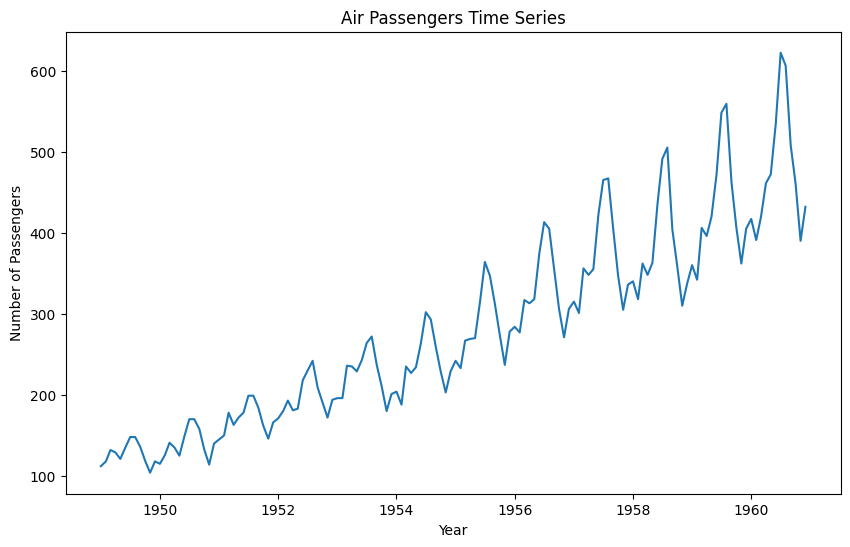

In [2]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.title('Air Passengers Time Series')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()


# Крок 2: Попередня обробка даних

Далі необхідно підготувати дані та розділимо їх на набори для навчання та тестування.

Масштабування функцій має важливе значення для моделей нейронних мереж, щоб гарантувати, що всі вхідні ознаки знаходяться в однаковому діапазоні, запобігаючи домінуванню будь-якої окремої ознаки в процесі навчання через її масштаб. У цьому методичному посібнику для виконання масштабування функції використано клас MinMaxScaler із модуля sklearn.preprocessing.


In [3]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


#Крок 3: Створення послідовностей для моделі LSTM

Далі створено послідовності вхідних даних і відповідних цільових значень для навчання моделі LSTM:

•	Визначено функцію create_sequences() для створення вхідних послідовностей і відповідних цільових значень для моделі LSTM. Функція приймає два аргументи: data (дані часового ряду) і seq_length (кількість часових кроків для огляду назад).

•	Ми переглядаємо дані, щоб створити послідовності довжини seq_length разом із відповідними цільовими значеннями, повертаючи масиви NumPy X, що містять вхідні послідовності, і y, що містять цільові значення, створюючи послідовності як для навчальних, так і для тестових наборів.


In [4]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


# Крок 4: Визначення та навчання моделі LSTM

Нижче визначено та навчено модель LSTM

Ми визначаємо модель LSTM за допомогою Sequential() і додаємо рівень LSTM із 50 одиницями, функцією активації ReLU та формою введення (seq_length, 1), де seq_length — це довжина вхідних послідовностей із щільним шаром з однією одиницею (для регресії). Модель компілюється з використанням оптимізатора Adam та функції втрат середньоквадратичної помилки.


In [5]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1014
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0824
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0632
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0450
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0279
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0229
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0103 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0094
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099  
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073 
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072 
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0079
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0060
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0058
Epoch 16/100
4/

# Крок 5: Прогнози та візуалізація

Далі зроблено прогнози за допомогою навченої моделі та оцінюється її ефективність і розуміння графіка фактичних точок даних і прогнозованої лінії тренду.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


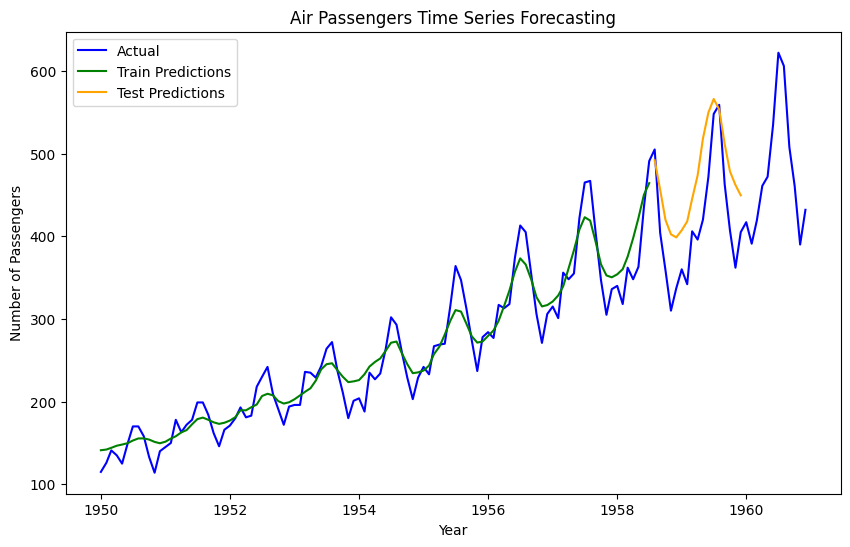

In [6]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(data.index[seq_length:], data['#Passengers'][seq_length:], label='Actual', color='blue')

# Plot training predictions
plt.plot(data.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green')

# Plot testing predictions
test_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(test_predictions))
plt.plot(data.index[test_pred_index], test_predictions, label='Test Predictions',color='orange')

plt.title('Air Passengers Time Series Forecasting')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


# Крок 6: Прогнозування на наступний період

Щоб точно зрозуміти можливість прогнозу за допомогою створеної моделі, нижче побудовано графік для періоду 30 місяців:

•	Ініціалізовано порожній список для зберігання прогнозованих значень, ми використовуємо останню послідовність з тестових даних для ініціалізації last_sequence з циклом через період прогнозу, щоб передбачити наступне значення за допомогою моделі.

•	Далі побудовано фактичні значення для тестового періоду разом із прогнозованими значеннями для наступних 30 місяців.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

<ipython-input-9-5ff46abf4cfd>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=data.index[-1], periods=forecast_period, freq='M'), forecast, label='Forecast')


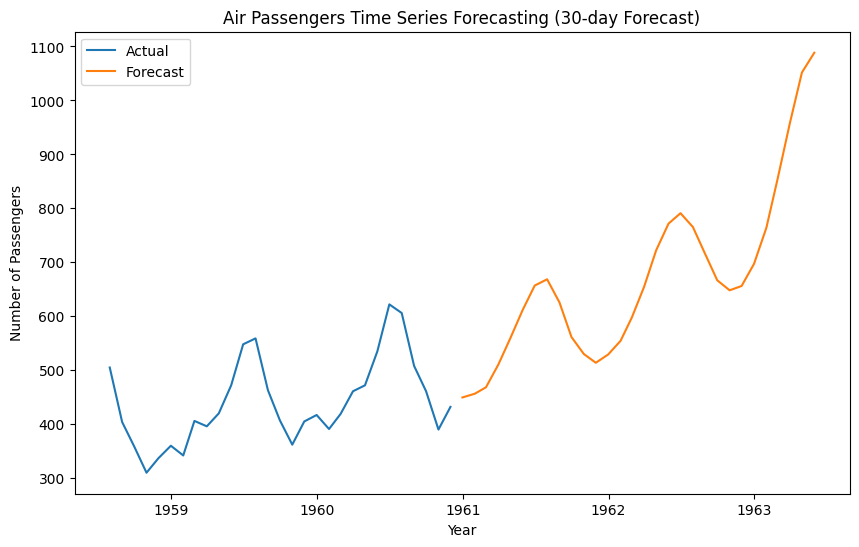

In [9]:
forecast_period = 30
forecast = []

# Use the last sequence from the test data to make predictions
last_sequence = X_test[-1]

for _ in range(forecast_period):
    # Reshape the sequence to match the input shape of the model
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    # Predict the next value
    next_prediction = model.predict(current_sequence)[0][0]
    # Append the prediction to the forecast list
    forecast.append(next_prediction)
    # Update the last sequence by removing the first element and appending the predicted value
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Inverse transform the forecasted values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(test_data):], scaler.inverse_transform(test_data), label='Actual')
plt.plot(pd.date_range(start=data.index[-1], periods=forecast_period, freq='M'), forecast, label='Forecast')
plt.title('Air Passengers Time Series Forecasting (30-day Forecast)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()



І фактичні дані, і прогноз відображають тенденцію до зростання, що вказує на загальне збільшення кількості авіапасажирів за цей період.

Сезонний характер: Фактичні дані (синя лінія) демонструють сезонний характер, причому піки, ймовірно, відповідають сезону свят або літніх подорожей. Прогноз (помаранчева лінія) певною мірою враховує цю сезонність, але виглядає трохи більш плавним.

# Завдання

1. Дослідити, як вплине на прогноз значення seq_length (кількість часових кроків для огляду назад). Спробуйте збільшити або зменшити цю велічіну й подивіться на результат.

2. Дослідити, як вплине на результати прогнозу кількість епох навчання моделі.